In [1]:
import sys
sys.path.append('../')

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from functools import reduce as reduce
from mpl_toolkits.mplot3d import axes3d

from raypy.utils.vector3 import vec3
from raypy.utils.constants import *
from raypy.geometry.primitive import Primitive
from raypy.geometry.collider import Collider

from abc import abstractmethod

# Ray Tracer

## Einleitung

Auf Deutsch bezeichnet der englische Begriff „Ray tracing“ das „Nachverfolgen von Strahlen“. Genauer gesagt: Lichtstrahlen. Als Grafik-Technologie ermöglicht Ray tracing die Simulierung von Lichteffekten. Ein Algorithmus sendet hierzu Strahlen in einer 3D-Grafik aus, verfolgt die Strahlenpfade und berechnet ein realistisches Beleuchtungsmodell.

In der realen Welt senden Lichtquellen Lichtstrahlen aus, die dann auf Objekte treffen, dort gebrochen, reflektiert oder gestreut werden und schlussendlich bei der Kamera ankommen.
Die von der Kamera erfassten Lichtstrahlen sind deshalb nur ein Bruchteil der Lichtstrahlen, die von der Lichtquelle zwar ausgesendet, von der Kamera aber nicht aufgenommen werden.

Um nur die, für die Kamera wichtigen, Lichtstrahlen zu berechnen, wird der Weg des Lichts beim Ray tracing entgegen der natürlichen Richtung berechnet.
Die Lichtstrahlen werden also von der Kamera ausgesendet und zurückverfolgt. Die folgende Grafik zeigt wie ein Ray aus der Kamera durch die Bildebene in den dreidimensionalen Raum gesendet wird.

<img src="assets/campixel.gif" alt="this slowpoke moves"  width="500" />

Jeder Durchtrittspunkt von einem Strahl, der von dem Augenpunkt ausgeht, stellt einen Pixel dar. Die Farbe dieser Pixel wird durch die sogenannte Rendergleichung berechnet. Diese Rendergleichung wird in unserem Raytracer von einem Path Tracing Algorithmus angenähert. Dieser Algorithmus wird auch Monte-Carlo-Raytracing genannt. Dieser ist dafür bekannt, realistisch wirkende Lichtverhältnisse darstellen zu können. Der Algorithmus verwendet statistische Berechnungen, um die Reflexionen und Brüche der ausgesendeten Strahlen beim Treffen von Objekten bestimmen zu können. Die Monte-Carlo-Technik bietet jedoch nur eine Annäherung an die korrekte Lösung der Rendergleichung. Damit diese Annäherung möglichst präzise ist, müssen pro Pixel mehrere Strahlen versendet werden und deren Farben miteinander verrechnet werden. Desto mehr Strahlen pro Pixel ausgesendet werden, desto kleiner ist die Abweichung zur richtigen Lösung der Rendergleichung.


## Numpy

Die Besonderheit dieses Raytracers ist die Nutzung von Numpy zur parallelen Berechnung der Rays.
Da ein Ray völlig unabhängig von anderen Rays berechnet werden kann, kann die Berechnung der Rays stark parallelisiert werden.

Eine Methode zur Parallelisierung ist neben mehreren Threads oder Prozessen die Berechnung mittels Matrizenrechnung in Numpy.
Ein Großteil der Funktionalität aus Numpy ist in C implementiert und ist damit um ein Vielfaches schneller als Python.

Das bietet den Vorteil, dass langsame For-Schleifen aus Python mit schnellen Matrizenrechnungen aus Numpy ersetzt werden können.
Des Weiteren muss so keine Parallelisierung im Sinne von mehreren Threads oder Prozessen eingebaut werden.
Der Nachteil ist, dass durch die Berechnung der Rays mittels Matrizen die Komplexität des Codes ansteigt. Wir sind der Meinung, dass der Geschwindigkeitsvorteil diesen Nachteil aber aufwiegt.

## Was ist ein Ray

Ein Ray, oder auch ein Lichtstrahl, ist die Kombination aus einem Ursprung und einer Richtung.
Ursprung und Richtung eines Rays können jeweils durch einen Vektor angegeben werden. Durch die Linearkombination 
des Ortsvektors (Ursprung) und des Richtungsvektors kann so jeder beliebige Punkt auf einem Ray angegeben werden.

<img src="assets/ray.png" width=300></img>

Die Gleichung für ein Ray ist also: $P(t)=\vec{O}+\vec{R}*t$

Die einfachste Implementierung eines Rays ist folgende:

In [2]:
class Ray:
  """Info of the ray and the media it's travelling"""

  def __init__(self, origin, dir):
      self.origin = origin  # the point where the ray comes from
      self.dir = dir  # direction of the ray

## Die Kamera

Die Kamera befindet sich am Augpunkt und schaut in eine definierte Richtung. Die Anzahl der ausgesendeten Rays hängt von der Anzahl der Pixel ab. 

In [3]:
class Camera():
    def __init__(self, look_from, look_at, screen_width=400, screen_height=400, field_of_view=90.):
        self.screen_width = screen_width
        self.screen_height = screen_height
        self.aspect_ratio = float(screen_width) / screen_height
        self.look_from = look_from
        self.look_at = look_at
        self.camera_width = np.tan(field_of_view * np.pi / 180 / 2.) * 2.
        self.camera_height = self.camera_width / self.aspect_ratio

        # camera reference basis in world coordinates
        self.cameraFwd = (look_at - look_from).normalize()
        self.cameraRight = (self.cameraFwd.cross(vec3(0., 1., 0.))).normalize()
        self.cameraUp = self.cameraRight.cross(self.cameraFwd)

        # Pixels coordinates in camera basis:
        self.x = np.linspace(-self.camera_width / 2., self.camera_width / 2., self.screen_width)
        self.y = np.linspace(self.camera_height / 2., -self.camera_height / 2., self.screen_height)

        # x holds all x values
        # y holds all y values
        # meshgrid creates a rectangular grid with all combinations of (x,y)
        # xx and yy hold the x and y values of the rectangular grid: https://stackoverflow.com/a/42404323
        xx, yy = np.meshgrid(self.x, self.y)
        self.x = xx.flatten()
        self.y = yy.flatten()

    def get_ray(self):

        # in each pixel, take a random position to avoid aliasing.
        x = self.x + (np.random.rand(len(self.x)) - 0.5) * self.camera_width / self.screen_width
        y = self.y + (np.random.rand(len(self.y)) - 0.5) * self.camera_height / self.screen_height

        # set ray direction in world space:
        # ray_origin = self.look_from + self.cameraUp + self.cameraRight
        ray_origin = self.look_from
        ray_dir = (self.look_from + self.cameraUp * y + self.cameraRight * x + self.cameraFwd - ray_origin).normalize()
        return Ray(origin=ray_origin, dir=ray_dir)


Die Berechnung der Rays erfolgt über eine Rasterisierung der Projektionsebene.
Die Projektionsebene befindet sich in z-Richtung eine Einheit von der Kamera entfernt.
Die Projektionsebene hat bei einem quadratischen Bild eine Abmessung von 2x2.
Mit `np.linspace` können gleichmäßig verteilte Zahlen über ein bestimmtes Intervall erstellt werden.

Bei einer Projektionsebene von 2x2 ist `camera_width` und `camera_height` bei 2.
Der folgende Code erzeugt also eine Array mit Werten von -1 bis 1 für x und für y.
Die Anzahl der Werte ist `screen_width` für die x Werte und `screen_height` für die y Werte.

```python
self.x = np.linspace(-self.camera_width / 2., self.camera_width / 2., self.screen_width)
self.y = np.linspace(self.camera_height / 2., -self.camera_height / 2., self.screen_height)
```

<img src="assets/rastertoworld.gif" height="500" />


### Die Funktion get_ray

Die Funktion get_ray gibt $screen\_width * screen\_height$ Rays zurück.

Der Augpunkt (die Position der Kamera) wird als Stützvektor des Rays verwendet. Die Richtung des Rays kann über eine Linearkombination der Basis des Kamera Koordinatensystems generiert werden. Als Faktoren werden die im Voraus berechneten Kombinationen von x und y Werten verwendet.

Um Aliasing zu vermeiden, werden alle x und y Werte mit einem zufälligen Offset versehen. Wird das Bild dann mit mehreren Samples berechnet geht der Aliasing Effekt verloren.

In [4]:
camera = Camera(screen_width=800 ,screen_height=450, look_from = vec3(0, 0, 10), look_at = vec3(0,0,0), field_of_view= 90)
rays = camera.get_ray()

Visualisiert man die Richtung der Rays als RGB Wert kann ein Bild generiert werden, dass die Richtung der Rays veranschaulicht.

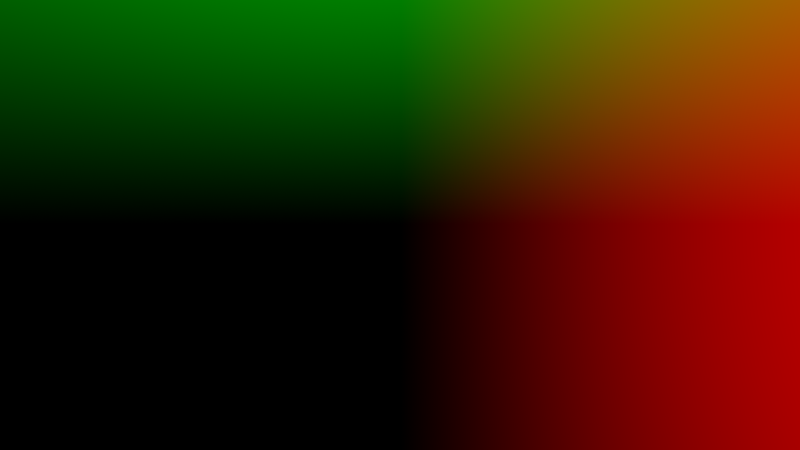

In [5]:
color = rays.dir.to_array()
img_RGB = []
for channel in color:
    img_RGB += [Image.fromarray((255 * np.clip(channel, 0, 1).reshape((camera.screen_height, camera.screen_width))).astype(np.uint8), "L")]

img = Image.merge("RGB", img_RGB)
display(img)

Das obige Bild zeigt die Richtungen der Rays als Farbe. Die Farben werden wie folgt auf die Richtung gemapped:
- Rot = x
- Grün = y
- Blau = z

Im Bild ist kein Blau zu sehen da alle Rays, die in die negative z-Richtung zeigen und negative Farbwerte nicht angezeigt werden können. Die negativen z-Werte werden von `np.clip(channel, 0, 1)` auf 0 gezogen.

## Schnittpunkt von Sphäre und Ray

Eine Sphäre ist die Oberfläche oder auch die Schale einer Kugel. Jeder Punkt  auf der Oberfläche einer Sphäre hat demnach den Radius r als Abstand zum Mittelpunkt der Sphäre.

<img src="assets/Sphere.jpg" width="500" />

Wird ein Lichtstrahl ausgesendet, muss berechnet werden ob und wie der Lichtstrahl die Sphäre schneidet. Es gibt hierbei 3 Möglichkeiten:
- Er verfehlt sie.
- Er streift sie.
- Er durchquert sie.

<img src="assets/IntersectionSphere.jpg" width="700" />

Wird die Sphäre verfehlt, gibt es **keinen** Schnittpunkt.

Wird die Sphäre nur berührt, gibt es **genau einen** Schnittpunkt (rot umkreist).

Wird die Sphäre durchkreuzt, gibt es 2 Schnittpunkte, einen Eintrittspunkt und einen Austrittspunkt. In diesem Fall interessiert uns nur der Schnittpunkt mit der kleineren Distanz zum Ursprung des Rays (rot umkreist).

Die Schnittpunkte haben exakt den Radius r als Distanz zum Mittelpunkt.

Bevor wir die Schnittpunkte berechnen schauen wir uns noch die unterschiedlichen Positionen des Ray Ursprungs an. Der Ursprung des Rays kann 3 Positionen haben:

- vor der Sphäre, also zwischen Kamera und Späre
- hinter der Späre
- in der Späre

<img src="assets/OriginRay.jpg" width="700" />

Möchte man nun die Schnittpunkte berechnen, benötigt man die Formel für den Ray:

$$P(t)=\vec{O}+\vec{R}*t$$

Aus dieser Formel können wir nun die Formeln für die Schnittpunkte aufstellen, $t_1$ und $t_2$ beschreiben wie weit vom Ursprung die Schnittpunkte auf der Strahlgerade entfernt sind.

$$P_1(t)=\vec{O}+\vec{R}*t_1$$

$$P_2(t)=\vec{O}+\vec{R}*t_2$$

Wir suchen nun die Werte $t_1$ und $t_2$. In der Abbildung oben sieht man, dass $t_1$ den Abstand des Ursprungs des Rays $O$ zum Punkt $P_1$ beschreibt und $t_2$ ist der Abstand des Ursprungs $O$ zum Punkt $P_2$.

Dafür brauchen wir die Gleichung der Sphäre.

Liegt der Radius im Ursprung $U (0,0,0)$ und der Punkt auf der Oberfläche so ergibt sich die Gleichung:
$$x^2 + y^2 + z^2 = r^2$$

Liegt der Radius nicht im Ursprung sondern im Punkt $M (M_x, M_y, M_z)$ ergibt sich:
$$(x-M_x)^2 + (y-M_y)^2 + (y-M_z)^2 = r^2$$

$x, y, z$ gehören in diesem Beispiel zu einem Punkt P, wodurch wir die Formel vereinfachen können:
$$(P-M) * (P-M) = (x-M_x)^2 + (y-M_y)^2 + (y-M_z)^2 = r^2$$

Wir suchen jetzt aber nicht irgendein Punkt P, sondern einen Punkt P der auf unserem Lichtstrahl $P(t)=\vec{O}+\vec{R}*t$ liegt. Daher setzen wir nun für P unsere Lichtstrahl-Gleichung ein:
$$(\vec{O}+\vec{R}*t-M) * (\vec{O}+\vec{R}*t-M) = r^2$$

Formen wir die quadratische Gleichung um, erhalten wir vereinfacht:
$$t^2 * \vec{R} + t * 2*\vec{R}*(\vec{O}-M) + (\vec{O}-M) * (\vec{O}-M) - r^2 = 0$$

Wie man sieht können wir jetzt einfach die Mitternachtsformel mit

$$ a = \vec{R} $$

$$ b = 2*\vec{R}*(\vec{O}-M) $$

$$ c = (\vec{O}-M) * (\vec{O}-M) - r^2 $$

anwenden, um die Werte $t_1$ und $t_2$ auszurechnen.


Anhand der Diskriminante kann bestimmt werden, wie viele Schnittpunkte es gibt:
- Diskriminante > 0: **zwei** Schnittpunkte
- Diskriminante = 0: **ein** Schnittpunkt
- Diskriminante < 0: **kein** Schnittpunkt


Nachfolgend sind 2 Klassen, um eine Sphäre darzustellen.

Die erste Klasse ist die **primitive** Darstellung, bedeutet damit werden die Parameter der Kugel festgelegt, wie Mittelpunkt, Radius, Material, ...

Die zweite Klasse implementiert die Aktionen die beim Aussenden eines Rays abgehandelt werden müssen, bedeutet das Ausrechnen des Schnittpunkts.

In [6]:
class Sphere(Primitive):
    def __init__(self, center, material, radius, max_ray_depth=5, shadow=True):
        super().__init__(center, material, max_ray_depth, shadow)
        self.collider_list += [SphereCollider(assigned_primitive=self, center=center, radius=radius)]
        self.bounded_sphere_radius = radius

    def get_uv(self, hit):
        return hit.collider.get_uv(hit)

In [7]:
class SphereCollider(Collider):
    def __init__(self,  radius, **kwargs):
        super().__init__(**kwargs)
        self.radius = radius

    def intersect(self, origin, direction):
        b = 2 * direction.dot(origin - self.center)
        c = self.center.square_length() + origin.square_length() - 2 * self.center.dot(origin) - (self.radius * self.radius)
        discriminant = (b ** 2) - (4 * c)
        # we will handle the case discriminant < 0 later
        # We can't just exit when discriminant is < 0 because we are doing matrix calculations to calculate all ray intersections at once
        sq = np.sqrt(np.maximum(0, discriminant))
        h0 = (-b - sq) / 2
        h1 = (-b + sq) / 2
        h = np.where((h0 > 0) & (h0 < h1), h0, h1)
        intersectionPoint = (origin + direction * h)
        surfaceNormal = ((intersectionPoint - self.center) * (1. / self.radius))
        ## calculate if the normal and the ray direction point against each other or in the same direction
        normalDirection = surfaceNormal.dot(direction)

        pred1 = (discriminant > 0) & (h > 0) & (normalDirection > 0)
        pred2 = (discriminant > 0) & (h > 0) & (normalDirection < 0)
        pred3 = True

        # return an array with hit distance and the hit orientation
        # because we did some matrix multiplications, we now have to select the correct distances
        return np.select([pred1, pred2, pred3],
                         [[h, np.tile(UPDOWN, h.shape)], [h, np.tile(UPWARDS, h.shape)], FARAWAY])

    def get_normal(self, hit):
        return (hit.point - self.center) / self.radius

## Schnittpunkt von Ebene und Ray

Damit ein Punkt auf einer Ebene liegt muss folgende Gleichung erfüllt sein:

$$(\vec{p} - \vec{p_0}) * \vec{n} = 0$$

- $\vec{p}$  Punkt auf Ebene
- $\vec{p_0}$ Mittelpunkt der Ebene
- $\vec{n}$ Normalenvektor der Ebene

Der Ray ist wie folgt definiert:
$$P = \vec{O}+\vec{R}*t$$

- $\vec{O}$ Stützvektor
- $\vec{R}$ Richtungsvektor

Daraus folgt:
$$((\vec{O}+\vec{R}*t) - \vec{p_0}) * \vec{n} = 0$$

Eine Umformung nach t ergibt:
$$t = \frac{(\vec{p_0} - \vec{O}) * \vec{n}}{\vec{R} * \vec{n}}$$

<img src="assets/PlaneIntersection.jpg" width=300></img>

Setzt man t wieder in die Formel des Rays ein, erhält man den Schnittpunkt von Ray und Ebene. Der Verbindungsvektor des Schnittpunks mit dem Mittelpunkt der Ebene liegt in der Ebene.
Projiziert man diesen Verbindungsvektor auf die Achsen der Ebene, kann bestimmt werden, ob der Endpunkt der Schnittpunkt innerhalb einer gegeben Breite und Länge der Ebene liegt.

Nachfolgend sind 2 Klassen, um eine Ebene darzustellen.

Die erste Klasse ist die **primitive** Darstellung, bedeutet damit werden die Parameter der Ebene festgelegt, wie Mittelpunkt, Breite, Höhe, Material, ...

Die zweite Klasse implementiert die Aktionen die beim Aussenden eines Rays abgehandelt werden müssen, bedeutet das Berechnen des Schnittpunkts.

In [8]:
class Plane(Primitive):
    def __init__(self, center, material, width, height, u_axis, v_axis, max_ray_depth=5, shadow=True):
        super().__init__(center, material, max_ray_depth, shadow)
        self.collider_list = [PlaneCollider(self, center, u_axis, v_axis, width/2, height/2)]
        self.width = width   
        self.height = height
        self.bounded_sphere_radius = np.sqrt((width/2)**2 + (height/2)**2)

In [9]:
class PlaneCollider(Collider):
    def __init__(self, assigned_primitive, center, u_axis, v_axis, w, h, uv_shift=(0, 0)):
        super().__init__(assigned_primitive, center)
        self.normal = u_axis.cross(v_axis).normalize()
        self.w = w
        self.h = h
        self.u_axis = u_axis
        self.v_axis = v_axis
        self.uv_shift = uv_shift

    def intersect(self, origin, direction):
        # https://samsymons.com/blog/math-notes-ray-plane-intersection/
        nominator = self.normal.dot(self.center - origin)
        denominator = self.normal.dot(direction)
        denominator = np.where(denominator == 0., 1e-6, denominator)

        distance = nominator / denominator

        point = origin + direction * distance
        vec_in_plane = point - self.center

        u = self.u_axis.dot(vec_in_plane)
        v = self.v_axis.dot(vec_in_plane)
        # projection from vec_in_plane on u_axis and v_axis

        hit_inside = (np.fabs(u) <= self.w) & (np.fabs(v) <= self.h) & (distance > 0)
        # check if the point is inside of the plane

        # distance has to be > 0, so we only consider hits in the positive direction
        hit_UPWARDS = (denominator < 0)   # we hit the plane against its normal vector
        hit_UPDOWN = np.logical_not(hit_UPWARDS)    # we hit the plane in the direction of its normal vector

        pred1 = hit_inside & hit_UPWARDS
        pred2 = hit_inside & hit_UPDOWN
        pred3 = True
        return np.select([pred1, pred2, pred3], [[distance, np.tile(UPWARDS, distance.shape)], [distance, np.tile(UPDOWN, distance.shape)], FARAWAY])

    def get_normal(self, hit):
        return self.normal

## Quader

Ein Quader wird mithilfe einer Länge, einer Breite und einer Höhe beschrieben.


<img src="assets/Cuboid.jpg" width=500></img>

Diese Parameter ermöglichen außerdem eine Rotation des Quaders und die Berechnung der Schnittpunkte des Quaders mit den Rays.

Zur Bestimmung der Schnittpunkte wird eine Diagonale durch den Quader gezogen, dessen Schnittpunkte mit der Oberfläche des Quaders berechnet werden.

lb = left botton in the front

rt = right top in the back

Die beiden Punkte lb und rt berechnen sich aus dem Mittelpunkt des Quaders C und der Hälfte der Länge, Breite und Höhe:

$$ lb = \vec{C} +
\begin{pmatrix}
\frac{l}{2} \\ \frac{h}{2} \\ \frac{b}{2}
\end{pmatrix}
$$

$$ rt = \vec{C} -
\begin{pmatrix}
\frac{l}{2} \\ \frac{h}{2} \\ \frac{b}{2}
\end{pmatrix}
$$

<img src="assets/CuboidDiagonale.jpg" width=500></img>

Möchte man nun den Quader rotieren (siehe rotate()) so wird zuerst das Punktprodukt aus den Basisvektoren (die 3 Einheitsvektoren) mit der Rotationsmatrix M berechnet.

Anschließend wird die Strecke zwischen dem Mittelpunkt und den Punkten $lb,rt$ berechnet $(lb-C), (rt-C)$, mit der Rotationsmatrix multipliziert und auf den Mittelpunkt addiert. Diese neuen Punkte $lb_n, rt_n$ werden noch mit den neuen Basisvektoren multipliziert, wodurch der Quader gedreht wurde.

<img src="assets/CuboidRotate.jpg" width=1200/>

## Schnittpunkt Quader mit Strahl

Die Berechnung eines Schnittpunkts von einem achsenparallelen Quader ist sehr simpel, schwierig wird es, wenn der Quader wie hier gedreht wird.

Um das Problem zu umgehen wird einfach zu Beginn der Strahl mit den Basisvektoren multipliziert, dadurch wird der Strahl gedreht, wodurch die Achsenparallelität wieder gegeben ist.

<img src="assets/AABB.jpg" width=500></img>

Siehe $O\_local\_basis$ für den neuen Ursprung des Strahls ($O_n$) und $D\_local\_basis$ für den neuen Richtungsvektor ($D_n$).

Ist die Parallelität gegeben, kann der Axis-aligned minimun bounding box (AABB) Algotithmus angewendet werden.

Hier wird zuerst für jede Richtung (x,y,z) ein Intervall berechnet.

Das untere Beispiel berechnet das Intervall in x-Richtung = (t1, t2):

$$ t1 = \frac{x_1 - O_nx}{D_{nx}} $$
$$ t2 = \frac{x_2 - O_nx}{D_{nx}} $$

$x_1$ = unterer, linker, vorderer Punkt

$x_2$ = unterer, rechter, hinterer Punkt

Diese Berechnung führt man für alle 3 Achsen durch.

Anschließend werden die Randwerte berechnet ??


Daraus lässt sich folgendes ablesen:

- $t_{max} < 0$: **ein** Schnittpunkt
- $t_{max} < t_min$: **kein** Schnittpunkt
- $t_{min} < 0$: Ursprung des Rays liegt im Quader

Um den Normalenvektor zu berechnen, wird benötigt um die Reflektion des Strahls zu bestimmen, wird erst ein Punkt P berechnet:

$$ P = Basisvektoren * (Schnittpunkt - \vec{C}) $$

Der Betrag des Punktes wird auf die Länge, Breite, Höhe normiert werden:

$$ P_n = \begin{pmatrix}
\frac{1}{b} \\ \frac{1}{h} \\ \frac{1}{l}
\end{pmatrix} * |P| $$

Was wir jetzt noch nicht wissen ist die Richtung des Normalenvektors.

Die Richtung des Normalenvektor ist abhängig von der Seite des Quaders auf der Schnittpunkt ist.

Um die Seite des Quaders zu bestimmen wird nach dem größten Wert von x,y,z gesucht.

Im nachfolgenden Beispiel haben wir ein Quader dessen Mittelpunkt bei $(0,0,0)$ liegt und eine Kantenlänge von 1 hat.

<img src="assets/AABBNormalvector.jpg" width=500></img>

Der Schnittpunkt des Rays (rot) ist bei Punkt $P (0,0.5,0)$.

Um den größten der drei Werte x,y,z zu bekommen, schauen wir uns die Beträge der Koordinaten an:
- $x = |0|$
- $y = |0.5|$
- $z = |0|$

Der größte Wert des Punktes P ist y.

Daraus kann nun der Normalvektor $N (n_x,n_y,n_z)$ bestimmt werden:

$n_x$ und $n_z$ werden auf Null gesetzt und $n_y$ also die Koordinate mit dem größten Wert auf ±1. Das Vorzeichen wird bestimmt durch das Vorzeichen der größten Koordinate, hier y. Da y einen positiven Wert hat ist $n_y = 1$.

Daraus ergibt sich für $N: (0,1,0)$, im Bild orange.

Das Entscheiden des Vorzeichens und das Zuweisen des Wertes 1 wird mithilfe der sign(x) Methode gemacht.

## Farbberechnung eines Rays

Wie zu Begin erwähnt handelt es sich hier um Path Tracing oder auch Monte-Carlo-Raytracing

Beim Path Tracing wird jeder Strahl, der in die Szene geschossen wird, beim Auftreffen auf Oberflächen reflektiert, gebrochen oder absorbiert, wobei jedes Mal (außer im Falle der Absorption) mindestens ein zufälliger Strahl generiert wird, der das Integral der Rendergleichung nähert. Der Anfangsstrahl sucht sich so seinen Weg (path) durch die Szene. Je mehr Anfangsstrahlen man verwendet, desto mehr nähert man sich dem idealen Bild an. Die Fehler der Näherung äußern sich als Varianz, was Bildrauschen entspricht. 

Die Berechnung des Farbe eines Rays erfolgt mit der Methode _get_ray_color_:

1. Es wird berechnet ob ein Ray mit einem Objekt der Scene kollidiert
2. Ist dies nicht der Fall, wird die Farbe Schwarz zurückgegeben
3. Trifft der Ray ein Objekt wird die Farbe des Rays am Schnittpunkt berechnet
4. Trifft der Ray ein Licht emittierendes Material, wird einfach die Farbe dieses Materials zurückgegeben.
6. Trifft der Ray auf ein diffuses Objekt, werden weitere Rays erzeugt, deren Farbe dann rekursiv berechnet wird. Dazu mehr im Kapitel zu diffusen Materialien. 


## Diffuse Materialien

Die Farbe von diffusen Objekten, besteht aus einer Überlagerung ihrer eigenen Farbe (Albedo) und den Farben des auf dem Objekt auftreffenden Lichts. Licht das von einer diffusen Oberfläche gestreut wird, hat eine zufällige Richtung. Die Abbildung zeigt, wie Lichtstrahlen an zwei diffusen Spähren gestreut und in zufällige Richtungen weitergesendet werden.

<img src="assets/DiffuseMaterialRayReflection.jpg" width=500></img>

Die Implementierung der diffusen Materialien erlaubt es die Charakteristika etwas anzupassen. 
- Die Anzahl der reflektierten Strahlen gibt an, wie viele Rays ausgehend von einem Schnittpunkt rekursiv berechnet werden
- Die Anzahl der diffusen Reflexionen gibt an, wie oft ein Ray an diesem Material reflektiert wird, bis die Farbe Schwarz zurückgegeben wird. Je mehr Reflexionen nach einem Treffer auf dem Material erlaubt sind, desto weiter steigt die Genauigkeit der Lösung auf Kosten der Geschwindigkeit.
- Das Ambient weight gibt an, wie stark sich die Farbe des Materials mit den Farben der eintreffenden Lichtstrahlen vermischt.

In dieser Implementierung wird nur der erste eintreffende Strahl in mehrere Strahlen reflektiert, damit die Geschwindigkeit der Berechnung nicht zu sehr verschlechtert wird. 
Um die Geschwindigkeit in einem akzeptablen Bereich zu halten, werden nur direkt von der Kamera kommende Rays durch mehrere diffuse Rays berechnet. Rays, die schon von einem diffusen Objekt ausgesendet wurden, selbst also diffuse Rays sind, werden nur noch durch einen einzelnen diffusen Ray weiter berechnet.

### Einfache Darstellung diffuser Materialien

Die einfachste Methode zur Berechnung von diffusen Strahlen ist die Berechnung durch einen Punkt in einer Einheitssphäre auf der Oberfläche des diffusen Objekts.

Am Schnittpunkt $P$ des Rays wird zuerst der Normalenvektor der Oberfläche des Objekts berechnet. Setzt man den normierten Normalenvektor am Punkt $P$ an, erhält man je nach Ausrichtung des Normalenvektors einen Punkt innerhalb und außerhalb des Objekts. Für die Berechnung der diffusen Rays ist nur der Punkt außerhalb des Objekts interessant. An diesem Punkt kann eine Kugel mit dem Durchmesser 1 berechnet werden. Wählt man nun einen zufälligen Punkt innerhalb dieser Kugel und verbindet diesen mit dem Schnittpunkt $P$ erhält man einen zufälligen Ray, ausgehend vom Schnittpunkt $P$.

<img src="assets/DiffuseMaterialNormalvectors.jpg" width=500></img>

Der folgende Code demonstriert die Berechnung zufälliger Punkte auf einer Sphäre mit dem Radius 1.

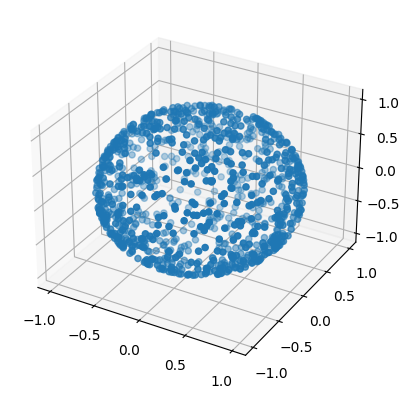

In [11]:
def random_in_unit_sphere(shape):
    #https://mathworld.wolfram.com/SpherePointPicking.html
    phi = np.random.rand(shape)*2*np.pi
    u = 2.*np.random.rand(shape) - 1.
    r = np.sqrt(1-u**2)
    return vec3( r*np.cos(phi),  r*np.sin(phi), u)

randoms = np.array([random_in_unit_sphere(1) for _ in range(1000)])
x = np.array([i.x for i in randoms])
y = np.array([i.y for i in randoms])
z = np.array([i.z for i in randoms])
fig = plt.figure()

ax = fig.add_subplot(projection='3d')
ax.scatter(x,y,z)

### Genaue Berechnung diffuser Materialien

Wie eben erwähnt, handelt es sich bei der obigen Methode um eine vereinfachte Berechnung eines zufälligen Rays.
Die genauere Methode berechnet einen Ray aus einer, auf der Objektoberfläche aufgesetzten, Hemisphäre.

### Effiziente Berechnung diffuser Materialien durch PDF

Die Schwierigkeit der Berechnung diffuser Materialien liegt in der globalen Beleuchtung oder auch "global illumination".

Die Simulation von globaler Beleuchtung an sich ist einfach. Das Hauptproblem bei der globalen Beleuchtung ist jedoch, dass sie, egal was man tut, teuer und ineffizient zu simulieren ist.

Aber was ist globale Beleuchtung überhaupt? Wir sehen Dinge, weil das von Lichtquellen wie der Sonne ausgestrahlte Licht an der Oberfläche der Objekte abprallt. Wenn Lichtstrahlen nur einmal von der Oberfläche eines Objekts reflektiert werden, um das Auge zu erreichen, spricht man von direkter Beleuchtung. Wenn eine Lichtquelle jedoch Lichtstrahlen aussendet, prallen diese häufiger mehrfach an der Oberfläche von Objekten ab, bevor sie das Auge erreichen (dies hängt natürlich von der Konfiguration der Scene ab). Um diesen Fall von der direkten Beleuchtung zu unterscheiden, sprechen wir dann von indirekter Beleuchtung: Die Lichtstrahlen folgen komplexen Pfaden, während sie von Objekt zu Objekt abprallen, bevor sie in unsere Augen gelangen. Manche Oberflächen sind nicht direkt einer Lichtquelle (oft der Sonne) ausgesetzt, dennoch sind sie nicht völlig schwarz. Das liegt daran, dass sie immer noch Licht empfangen, weil das Licht von einer Oberfläche zur anderen abprallt.

Die Schwierigkeit, die globale Beleuchtung effektiv zu berechnen, liegt darin, die für die Beleuchtung wichtigen Rays zu berechnen. Eine Lösung hier für ist das Monte-Carlo-Raytracing mit Importance Sampling von Lichtquellen mithilfe von Wahrscheinlichkeitsdichtefunktionen (PDF).

Eine genau Erklärung für Global Illumination und Path Tracing kann [hier](https://www.scratchapixel.com/lessons/3d-basic-rendering/global-illumination-path-tracing/introduction-global-illumination-path-tracing.html) nachgelesen werden.


## Wahrscheinlichkeitsdichtefunktionen

Die Wahrscheinlichkeitsdichtefunktionen geben an wie hoch die Wahrscheinlichkeit ist, dass ein Strahl in eine bestimmte Richtung reflektiert wird. Abhängig von dieser Wahrscheinlichkeit kann einem Ray eine Gewichtung verliehen werden und dadurch mit weniger Samples ein besseres Endergebnis erzeugt werden. 

In [12]:
class PDF:
    """Probability density function"""
    @abstractmethod
    def value(self,ray_dir):
        """get probability density function value at direction ray_dir"""
        pass

    @abstractmethod
    def generate(self):
        """generate random ray directions according the probability density function"""
        pass

### Cosinus PDF

Die Cosinus PDF generiert einen Ray innerhalb einer Hemisphäre auf der Oberfläche des Objekts. 

Der Wert der PDF hängt von der Richtung des Normalenvektors am Schnittpunkt von Ray und Objekt ab. Um die Berechnung der PDF einfacher zu halten, wird zuerst der zufällige Ray ausgehend vom Ursprung berechnet. Dann wird der Ray in ein am Schnittpunkt generiertes Koordinatensystem verschoben und so an die richtige Stelle gebracht.

Der Ray wird in Kugelkoordinaten berechnet.
Dafür werden die Winkel Phi $\varphi$ und Theta $\theta$ zufällig gewählt.
Damit eine Hemisphäre im positiven Bereich der z-Achse entsteht, werden die Winkel $\varphi$ und $\theta$ in folgenden Bereichen gewählt:
- $\varphi$ : $ [0; 2\pi] $
- $\theta$  : $ [0; 0.5\pi] $

<img src="assets/Kugelkoord.png">

Die Kugelkoordinaten werden dann in kartesische Koordinaten umgerechnet und der Ray in das Koordinatensystem am Schnittpunkt verschoben.

Der Wahrscheinlichkeitswert der Cosinus PDF beträgt $\frac{cos(\theta)}{\pi}$.
Die Herleitung der Cosinus PDF ist [hier](https://www.scratchapixel.com/lessons/3d-basic-rendering/global-illumination-path-tracing/global-illumination-path-tracing-practical-implementation.html) zu finden.

Die folgende Klasse zeigt die Cosinus PDF.

In [13]:
class CosinePdf(PDF):
    """Probability density Function"""
    def __init__(self, shape, normal):
        self.shape = shape
        self.normal = normal

    def value(self, ray_dir):
        return np.clip(ray_dir.dot(self.normal), 0., 1.) / np.pi
        # for diffuse materials, the scattering PDF is cos(θ) / pi
        # which is the same as ray_dir.dot(normal) / pi

    def generate(self):
        ax_w = self.normal
        a = vec3.where(np.abs(ax_w.x) > 0.9, vec3(0, 1, 0), vec3(1, 0, 0))
        ax_v = ax_w.cross(a).normalize()
        ax_u = ax_w.cross(ax_v)
        # create basis

        phi = np.random.rand(self.shape) * 2 * np.pi
        theta = np.random.rand(self.shape) * 0.5 * np.pi

        x = np.sin(theta) * np.cos(phi)
        y = np.sin(theta) * np.sin(phi)
        z = np.cos(theta)

        return ax_u * x + ax_v * y + ax_w * z

Der folgende Code erzeugt mit der Cosinus PDF Funktion eine Punktewolke in der Form einer Hemisphäre im positiven Bereich der z-Achse.
Dafür wird das Objekt der Klasse mit der Normalen `vec3(0,0,1)` initialisiert. Anschließend werden 1000 zufällige Punkte durch die PDF Funktion generiert und geplottet.

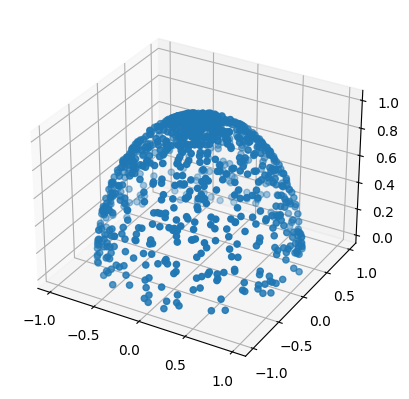

In [14]:
pdf = CosinePdf(1, vec3(0,0,1))
randoms = np.array([pdf.generate() for _ in range(1000)])
x = np.array([i.x for i in randoms])
y = np.array([i.y for i in randoms])
z = np.array([i.z for i in randoms])
fig = plt.figure()

ax = fig.add_subplot(projection='3d')
ax.scatter(x,y,z)

### Spherical Caps PDF

Die Spherical Caps PDF berechnet dient dem Importance Sampling von z.B. Lichtquellen. Hierzu werden aus einer Einheitssphäre Teile (Hauben) ausgeschnitten, in deren Richtung z.B. eine Lichtquelle liegt. Das führt dazu, dass alle Strahlen, die aus einer ausgeschnittenen Haube ausgewählt werden, zu einer Lichtquelle zeigen.

Wie auch schon bei der Cosinus PDF werden alle Rays ausgehend vom Ursprung berechnet und anschließend in das Koordinatensystem des Schnittpunkts verschoben.

Die Größe des ausgeschnittenen Teils (der Haube) wird basierend auf dem _bounded_sphere_radius_ eines jeden Objekts und dessen Entfernung zum Schnittpunkt berechnet. Berechnet man den $arcsin(\frac{bounded\_sphere\_radius}{distance})$ erhält man den maximalen Winkel $\theta_{max}$, der Kugelhaube.

Wählt man nun den Winkel Theta $\theta$ im Intervall $[0;\theta_{max}]$ und den Winkel Phi $\varphi$ im Intervall $[0;2\pi]$ erhält man eine Kugelhaube.

Das unten stehende Bild dient nochmal der Veranschaulichung der Kugelkoordinaten.

<img src="assets/Kugelkoord.png">

Die Klasse _SphericalCapsPdf_ implementiert die beschriebene Funktion.

In [15]:
class SphericalCapsPdf(PDF):
  """Probability density Function"""
  def __init__(self,shape, origin, importance_sampled_list):
    self.shape = shape
    self.origin = origin
    self.importance_sampled_list = importance_sampled_list
    self.l = len(importance_sampled_list)

  def value(self, ray_dir):
    PDF_value = 0.
    for i in range(self.l):
        PDF_value +=  np.where( ray_dir.dot(self.ax_w_list[i]) > self.cosθmax_list[i] , 1/((1 - self.cosθmax_list[i])*2*np.pi) , 0. )
    PDF_value = PDF_value/self.l
    return PDF_value


  def generate(self):
    shape = self.shape
    origin = self.origin
    importance_sampled_list = self.importance_sampled_list
    importanceLength = self.l

    # mask to randomly choose an object from the importance_sampled_list
    mask = (np.random.rand(shape) * importanceLength).astype(int)
    mask_list = [None]*importanceLength

    theta_max_list = [None]*importanceLength
    ax_u_list = [None]*importanceLength
    ax_v_list = [None]*importanceLength
    ax_w_list = [None]*importanceLength

    for i in range(importanceLength):
        # generate basis for every importance sampled object
        # w ist the vector from the ray origin to the importance sampled object
        ax_w_list[i] = (importance_sampled_list[i].center - origin).normalize()
        a = vec3.where( np.abs(ax_w_list[i].x) > 0.9 , vec3(0,1,0) , vec3(1,0,0))
        # generate the basis
        ax_v_list[i] = ax_w_list[i].cross(a).normalize()
        ax_u_list[i]  = ax_w_list[i].cross(ax_v_list[i])
        mask_list[i] = mask == i
        
        target_distance = np.sqrt((importance_sampled_list[i].center - origin).dot(importance_sampled_list[i].center - origin))
        # target distance is the distance between the hit point (the origin of the new ray) and the center of the importance sampled object
        theta_max_list[i] = np.arcsin(importance_sampled_list[i].bounded_sphere_radius / target_distance)

    self.cosθmax_list = np.cos(theta_max_list)
    self.ax_w_list = ax_w_list
    
    theta_max = np.select(mask_list, theta_max_list)
    ax_w =  vec3.select(mask_list, ax_w_list)
    ax_v =  vec3.select(mask_list, ax_v_list)
    ax_u =  vec3.select(mask_list, ax_u_list)

    phi = np.random.rand(shape)*2*np.pi
    theta = np.random.rand(shape) * theta_max

    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)


    ray_dir = ax_u*x + ax_v*y + ax_w*z
    return ray_dir

Der folgende Code erzeugt eine Liste von Objekten zum importance sampling.
Der Schnittpunkt oder Ursprung für den neuen Ray ist im Ursprung. Anschließend werden 1000 Punkte durch die SphericalCapsPdf erzeugt und visualisiert.

(-1.0, 1.0)

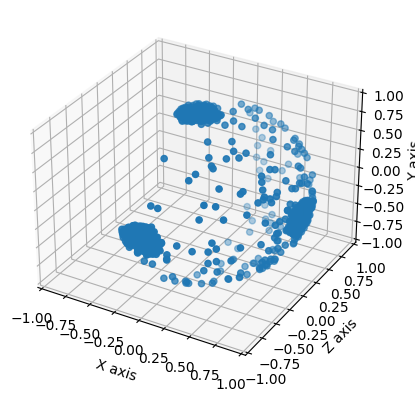

In [16]:
from raypy.geometry.sphere import Sphere

importance_sampled_list = [
  Sphere(center=vec3(0, 5, 0), material=None, radius=1), 
  Sphere(center=vec3(0, 0, 5), material=None, radius=1),
  Sphere(center=vec3(5, 0, 0), material=None, radius=1),
  Sphere(center=vec3(1, 0, 0), material=None, radius=1)
]

# origin is at vec3(0,0,0)
pdf = SphericalCapsPdf(1, vec3(0,0,0), importance_sampled_list)
randoms = np.array([pdf.generate() for _ in range(1000)])
x = np.array([i.x for i in randoms])
y = np.array([i.y for i in randoms])
z = np.array([i.z for i in randoms])
fig = plt.figure()

ax = fig.add_subplot(projection='3d')
ax.scatter(x,-z,y)
ax.set_xlabel('X axis')
ax.set_ylabel('Z axis')
ax.set_zlabel('Y axis')
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-1, 1)


Im Diagramm sind drei kleine und eine große Kugelhaube zu erkennen. Die drei kleinen Kugelhauben stammen von den drei Sphären, die jeweils 5 LE in x, y oder z entfernt vom Ursprung liegen. Der Radius der Kugelhaube ist dadurch klein. Die große Kugelhaube entsteht durch die Sphäre, die nur eine LE in positiver x-Richtung entfernt ist.

### Vermischung der beiden PDFs

Die optimalen Ergebnisse werden erzielt, wenn beide PDFs gemischt werden.

Die Umsetzung ist simpel, da man sich die Eigenschaften der Wahrscheinlichkeitsdichtefunktion zu Nutze machen kann. Da eine PDF durch ihre Normiertheit immer gleich 1 sein muss, kann man zwei Funktionen mit der nachfolgenden Formel verrechnen:
$$mixedPDF=w*PDF1+(1-w)*PDF2 \qquad w=[0 ,1]$$

Durch die Gewichtung „w“ sind die Eigenschaften einer PDF erfüllt und können angewendet werden.


In [17]:
class MixedPdf(PDF):    
    """Probability density Function"""
    def __init__(self,shape, pdf1, pdf2, pdf1_weight = 0.5):

        self.pdf1_weight = pdf1_weight
        self.pdf2_weight = 1. - pdf1_weight
        self.shape = shape
        self.pdf1 = pdf1
        self.pdf2 = pdf2


    def value(self,ray_dir):
        return self.pdf1.value(ray_dir) * self.pdf1_weight  + self.pdf2.value(ray_dir) * self.pdf2_weight
    
    def generate(self):
        mask = np.random.rand(self.shape)
        return vec3.where( mask < self.pdf1_weight, self.pdf1.generate(), self.pdf2.generate() )

## Gamma Korrektur

Eine Gammakorrektur wird in abbildenden Systemen benötigt, um das nichtlineare Helligkeitsempfinden des menschlichen Auges zu kompensieren. Das Auge reagiert beim Anstieg auf eine doppelte Helligkeit im physikalischen Sinne nicht zwangsläufig mit einer Verdopplung der Helligkeitsempfindung.

Die Gamma Korrektur wird durch folgende Formel durchgeführt:

$$
y(u) = \begin{cases}
  12.92 * u  & u <= 0.0031308\\
  1.055 * u^{\frac{1}{2.4}} - 0.55  & \text sonst
\end{cases}
$$

## Endergebnis

Das folgende Bild hat eine Auflösung von 1400x1400 Pixeln und wurde mit 700 Samples berechnet. Die Rechenzeit betrug trotz der Parallelisierung durch Numpy ungefähr 27 Stunden. Keine besonders gute Zeit, wenn man z.B. einen ganzen Film durch einen Ray Tracer berechnen lassen möchte.

<img src="assets/result-1400x1400-700_samples.png"></img>